# 음성 인식하기
* unzip -qq -d ./audio audio.zip
* pip install matplotlib
* pip install librosa
* pip install tqdm

# 모델링

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D
from tensorflow.keras.layers import Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import GRU, Bidirectional

In [2]:
SAMPLING_RATE = 8000
DROPOUT = 0.3
inputs = Input(shape=(SAMPLING_RATE, 1))

x = BatchNormalization()(inputs)
# 첫 번째 합성곱
x = Conv1D(filters=8, kernel_size=13, activation='relu')(x) # padding='valid', strides=1,
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(rate=DROPOUT)(x)

# 두 번째 합성곱
x = Conv1D(filters=16, kernel_size=11, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(rate=DROPOUT)(x)

# 세 번째 합성곱
x = Conv1D(filters=32, kernel_size=9, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(rate=DROPOUT)(x)
x = BatchNormalization()(x)

# 첫 번째 GRU 층
x = Bidirectional(GRU(units=128, return_sequences=True), merge_mode='sum')(x)
# 두 번째 GRU 층
x = Bidirectional(GRU(units=128, return_sequences=True), merge_mode='sum')(x)
# 세 번째 GRU 층
x = Bidirectional(GRU(units=128, return_sequences=False), merge_mode='sum')(x)

# 은닉층
x = BatchNormalization()(x)
x = Dense(units=256, activation='relu')(x)

# 출력층
outputs = Dense(units=5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 batch_normalization (Batch  (None, 8000, 1)           4         
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2662, 8)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424  

# 사운드파일 읽어오기

In [3]:
import librosa
import librosa.display # matplitlib에 의존함

In [4]:
sound, rate = librosa.load('yes-sample.wav')

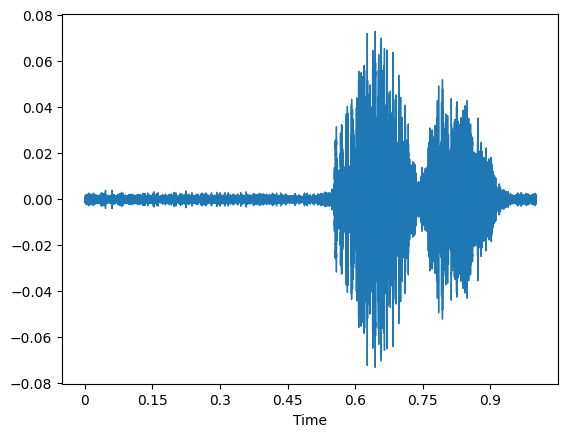

In [5]:
import matplotlib.pyplot as plt

librosa.display.waveshow(sound, sr=rate)
plt.show()

In [6]:
import IPython
IPython.display.Audio('yes-sample.wav')

In [7]:
# audio 디렉토리의 디렉토리를 읽고 레이블로 만들어 인코딩함
import os

AUDIO_PATH = './audio'
dirs = [f for f in os.listdir(AUDIO_PATH) if not os.path.isdir(f) ]
print(dirs)

['go', 'happy', 'seven', 'stop', 'yes']


In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(dirs)
labels = encoder.classes_
print(labels) # labels = ['go' 'happy' 'seven' 'stop' 'yes']

['go' 'happy' 'seven' 'stop' 'yes']


In [9]:
# 오디오 파일 읽기
from tqdm import tqdm
import numpy as np

def read_wave():
    all_wave = []
    all_label = []
    for label in tqdm(labels):
        path = AUDIO_PATH + '/' + label
        waves = [f for f in os.listdir(path)]

        for wav in waves:
            file = path + '/' + wav
            samples, rate = librosa.load(file, sr=16000)
            samples = librosa.resample(samples, orig_sr=rate, target_sr=SAMPLING_RATE)

            if(len(samples)==SAMPLING_RATE):
                all_wave.append(samples)
                all_label.append(label)

    all_label = encoder.transform(all_label)
    # all_label = to_categorical(all_label, num_classes=len(labels))
    all_wave = np.array(all_wave).reshape(-1, SAMPLING_RATE, 1)

    print('Resampling 종료')
    print('전체 샘플링 수:', len(all_wave))

    return all_wave, all_label

In [10]:
from tqdm import tqdm

if os.path.exists('arrays.npy'):
    with open('arrays.npy', 'rb') as f:
        all_wave = np.load(f)
        all_label = np.load(f)
else:
    all_wave, all_label = read_wave()
    with open('arrays.npy', 'wb') as f:
        np.save(f, all_wave)
        np.save(f, all_label)
    print('데이터 파일 완성')

# 데이터셋 분리

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_wave, all_label)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(666, 8000, 1) (223, 8000, 1) (666,) (223,)


# 훈련을 정의하고 학습시킴

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [13]:
%%time
if os.path.exists('speech.h5'):
    model.load_weights('speech.h5')
else:
    history = model.fit(x=X_train, y=y_train, epochs=100, batch_size=128, verbose=1)
    model.save_weights('speech.h5')

CPU times: total: 31.2 ms
Wall time: 52.2 ms


In [14]:
model.evaluate(x=X_test, y=y_test, verbose=1)

7/7 [==============================] - 5s 234ms/step - loss: 0.3097 - accuracy: 0.9417


[0.30972883105278015, 0.9417040348052979]

# 샘플 오디오 읽어와 Speech2Text 하기

In [23]:
# 임의 파일 불러오기

import IPython
import os, random

rand_dir = random.choice(os.listdir("./audio"))
print(rand_dir)
rand_path = random.choice(os.listdir("./audio/" + rand_dir))
picked = os.path.join("./audio", rand_dir, rand_path)
picked_label = rand_dir
print(picked)
IPython.display.Audio(picked)

happy
./audio\happy\ad340ed7_nohash_0.wav


In [ ]:
# 사운드 읽어 텍스트 예측 후 반환하는 함수
def audio_to_text(audio):
    pred = model.predict(audio.reshape(1, SAMPLING_RATE, 1))
    index = np.argmax(pred[0])
    return labels[index]

In [25]:
# 오디오 loading, resampling, padding and reshape
# 텍스트 분류 예측
from tensorflow.keras.preprocessing.sequence import pad_sequences

y, sr = librosa.load(picked) # default sampling rate = 22050
sample = librosa.resample(y, orig_sr=sr, target_sr=SAMPLING_RATE)
sample = pad_sequences(np.array(sample).reshape(1, -1),
                       maxlen=SAMPLING_RATE, padding='post',
                       dtype=float)
sample = np.array(sample).reshape(-1, SAMPLING_RATE, 1)
print(audio_to_text(sample))

[ 1.1758337e-05  3.7900048e-05 -1.1009040e-06 ...  2.0298754e-05
  4.3593864e-05  6.3935462e-05]
8000
8000
1/1 [==============================] - 0s 64ms/step
happy
